In [2]:
import os; os.chdir("..")
import sys; sys.path.append("../../Path_Scripts")

In [19]:
import gym, fastjet
from hyperrectangles.rules import diagram, rule
from rlutils import build_params, make
from rlutils.observers.pbrl import load
import numpy as np
from torch import from_numpy, device, load as pt_load
from torch.cuda import is_available
import matplotlib.pyplot as plt
P = build_params(["agent.pets=0"], root_dir="config")["agent"]

In [20]:
TASK = "follow"
DYNAMICS_PATH = "pretrained_dynamics/follow_v1.dynamics"
PBRL_PATH = "graphs_and_models/fastjet/follow/charmed-totem-113/200.pbrl"
RENDER = False

reward_model = load(PBRL_PATH, {"reward_source": "model"}).model
P["reward"] = reward_model
P["pretrained_model"] = pt_load(DYNAMICS_PATH, map_location=device("cuda" if is_available() else "cpu"))
agent = make("pets", hyperparameters=P,
    env=gym.make("FastJet-v0", 
            task=TASK, 
            skip_frames=25,
            render_mode="human" if RENDER else False,
            camera_angle="outside_target_bg"
    )
)

Loaded graphs_and_models/fastjet/follow/charmed-totem-113/200.pbrl


Tree-structured reward function learned for the `follow` task

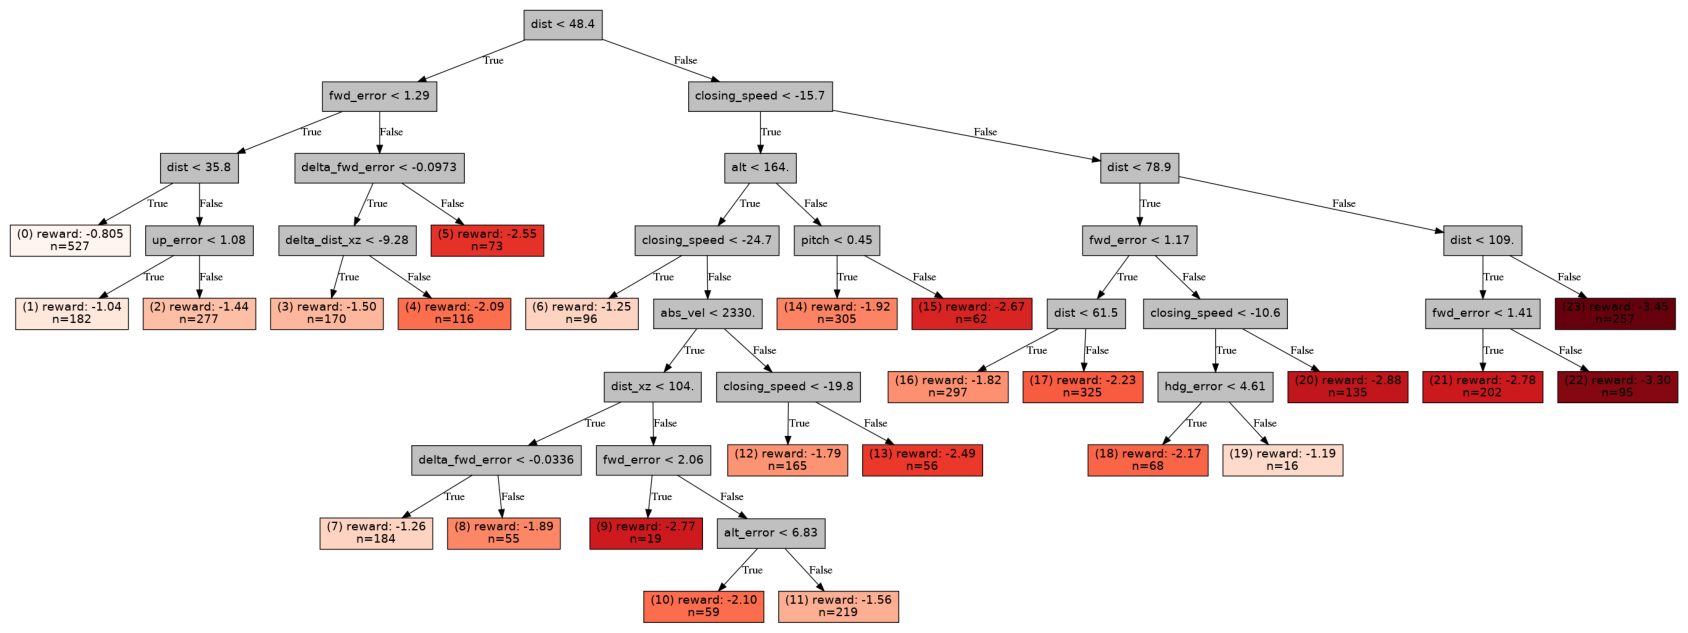

In [22]:
_, ax = plt.subplots(figsize=(30,30)); ax.axis("off")
ax.imshow(diagram(reward_model.tree, pred_dims=["reward"], colour_dim="reward", out_as="plt"));

Run model-based planning and action selection for a single state

In [27]:
agent.env.seed(0) # NOTE: Seeding for repeatability
state = agent.env.reset()
actions = []
for _ in range(10):
    action, data = agent.act(from_numpy(state).float().to(agent.device).unsqueeze(0), do_extra=True)
    actions.append(action)

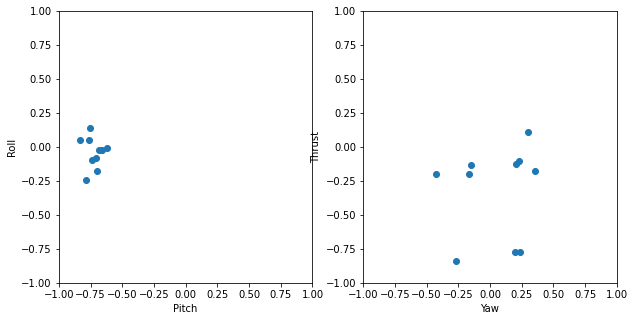

In [28]:
actions = np.array(actions)
_, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].scatter(actions[:,0], actions[:,1])
axes[1].scatter(actions[:,2], actions[:,3])

axes[0].set_xlabel("Pitch"); axes[0].set_xlim(-1, 1); axes[0].set_ylabel("Roll"); axes[0].set_ylim(-1, 1);
axes[1].set_xlabel("Yaw"); axes[1].set_xlim(-1, 1); axes[1].set_ylabel("Thrust"); axes[1].set_ylim(-1, 1);

`data` contains the simulated states and actions generated during each iteration of the planning algorithm

Use the tree to map this into an

$\text{num iterations}\times\text{num particles}\times\text{planning horizon}\times\text{num components}$

binary array representing reward component visitation

(50, 60, 10, 24)
First iteration, first particle
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


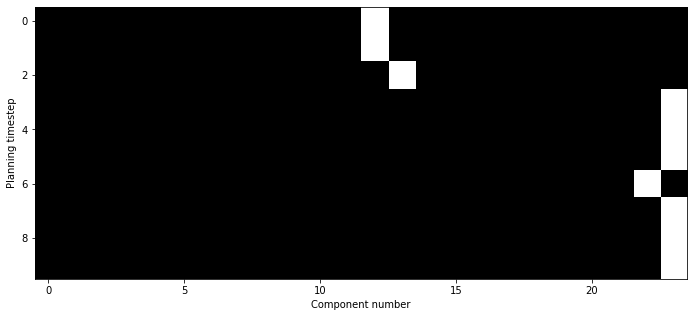

In [30]:
features = reward_model.featuriser(data["states"][:,:,:-1,:], data["actions"], data["states"][:,:,1:,:])
indices = reward_model.tree.get_leaf_nums(features.cpu().numpy(), one_hot=True)
print(indices.shape)
print("First iteration, first particle")
print(indices[0,0])
_, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(indices[0,0], cmap="gray")
ax.set_xlabel("Component number"); ax.set_ylabel("Planning timestep");

Average over the particles in each planning iteration to get visitation probabilities

First iteration visitation probabilities
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.95  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.183 0.517 0.3   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.15  0.333 0.3   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.217]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.183 0.183 0.2   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.433]
 [0.    0.    0.    0.    0.    0.    0.    0.067 0.05  0.    0.    0.017 0.083 0.067 0.    0.    0.    0.    0.    0.    0.    0.    0.017 0.7  ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.033 0.    0.    0.    0.    0.083 0.    0.    0.    0.    0.    0.    0.    0.    0.417 0.467]
 [0.    0.    0.    0.    0.    0.    0.    0.017 0.017 0.    0.    0.    0. 

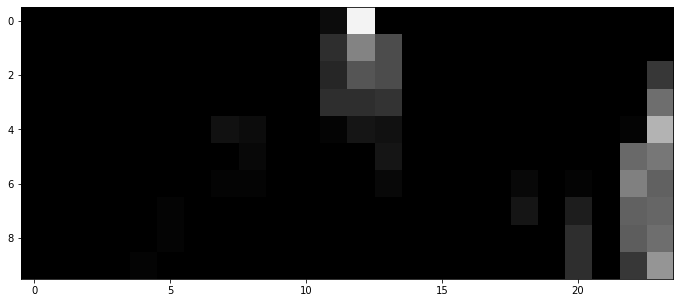

In [34]:
print("First iteration visitation probabilities")
print(indices[0].mean(axis=0))
_, ax = plt.subplots(figsize=(15,5))
ax.imshow(indices[0].mean(axis=0), cmap="gray", vmin=0, vmax=1)
print("Last iteration visitation probabilities")
print(indices[-1].mean(axis=0))

Subtract these probabilities and scale by the reward for each component to get a temporally-decomposed *Reward Difference Explanation (RDX)*
- Juozapaitis, Z., Koul, A., Fern, A., Erwig, M., & Doshi-Velez, F. (2019, January). Explainable reinforcement learning via reward decomposition. In IJCAI/ECAI Workshop on explainable artificial intelligence.

In [83]:
diff = indices[-1].mean(axis=0) - indices[0].mean(axis=0)
print("Last - first visitation difference")
print(diff)
print("RDX")
rdx = diff * reward_model.r.numpy()
print(rdx)
print("Sum of RDX = total difference in return =", rdx.sum())

Last - first visitation difference
[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.017  0.     0.333  0.    -0.317  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.1    0.     0.517 -0.05  -0.217  0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.15 ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.033  0.     0.6   -0.017 -0.15   0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.4  ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.017  0.     0.75  -0.033 -0.067  0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.667]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.017  0.     0.7    0.017 -0.05   0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.683]
 [ 0.     0.     0.     0.     0.     0.     0.     0.4    0.3    0.     0.     0.033  0.017 -0.017  0.     0.

Visualise the RDX

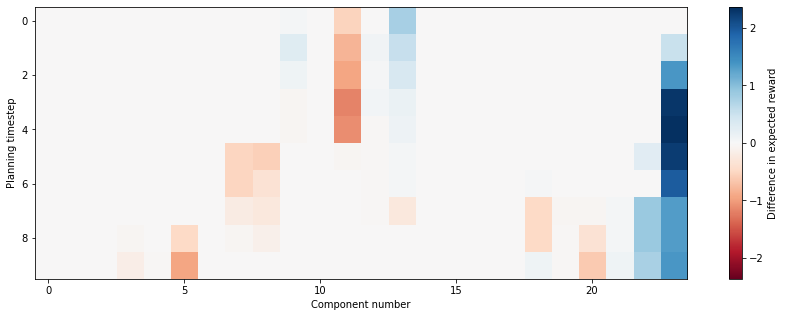

In [112]:
_, ax = plt.subplots(figsize=(15,5))

mx = abs(rdx).max()
im = ax.imshow(rdx, cmap="RdBu", vmin=-mx, vmax=mx);
ax.set_xlabel("Component number"); ax.set_ylabel("Planning timestep")
plt.colorbar(im, label="Difference in expected reward");

A human factors point: with this representation we can't unpick the influence of probability difference vs reward magnitude on the RDX

Representing the (temporally-summed) RDX in 2D as a scatter plot disentangles this

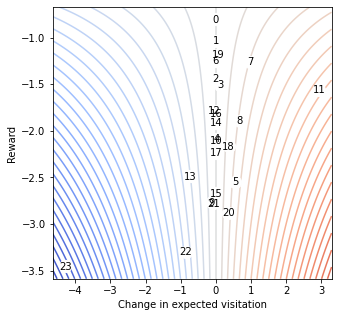

In [153]:
d = diff.sum(axis=0)
r = reward_model.r.numpy()

_, ax = plt.subplots(figsize=(5,5))
ax.scatter(d, r, c="w", s=150)
for x in range(len(r)): ax.annotate(x, xy=(d[x], r[x]), ha="center", va="center")

lims = ax.get_xlim(), ax.get_ylim()

X, Y = np.meshgrid(np.linspace(lims[0][0], lims[0][1], 100), np.linspace(lims[1][0], lims[1][1], 100))
Z = X*Y
mx = abs(Z).max()
ax.contour(X, Y, Z, levels=50, vmin=-mx, vmax=mx, cmap="coolwarm_r", zorder=-1)
ax.set_xlim(lims[0]); ax.set_ylim(lims[1])
ax.set_xlabel("Change in expected visitation"); ax.set_ylabel("Reward");

Compute the *Minimal Sufficient Explanation* (MSX): the smallest set of components required to demonstrate that the last iteration has higher return than the first

In [86]:
def compute_msx(rdx):
    """Compute a minimal sufficient explanation (MSX+, MSX-) given an RDX vector"""
    d = -rdx[rdx < 0.].sum() # Disadvantage d = negated sum of negative elements
    rank = rdx.argsort()
    v = 0. # Just-insufficient advantage v = sum of all but last element in MSX+
    for i, x in enumerate(reversed(rank)):
        assert rdx[x] > 0., "Advantage must be positive."
        if (v + rdx[x]) > d: break
        v += rdx[x]
    msx_pos = rank[-(i+1):] # MSX+ = positive elements required to overcome d
    dd = 0.
    for i, x in enumerate(rank):
        if (dd - rdx[x]) > v: break
        dd -= rdx[x]
    msx_neg = rank[:i+1] # MSX- = negative elements required to overcome v
    return msx_pos, msx_neg

msx_pos, msx_neg = compute_msx(rdx.sum(axis=0))
print("MSX+", msx_pos)

MSX+ [23]


In [10]:
print(rule(reward_model.tree.leaves[23]), "--->", reward_model.r[23].item())

dist >= 109. and closing_speed >= -15.7 ---> -3.454423189163208


This function also returns the *negative* MSX, which is the smallest set of components required to make the MSX necessary

In [69]:
print("MSX-", msx_neg)

MSX- [ 5 12  3 14 16  6]


In [74]:
rule(reward_model.tree.leaves[5])

'dist < 48.4 and fwd_error >= 1.29 and delta_fwd_error >= -0.0973'

TODO: Transition diagram representation